In [1]:
import scanpy as sc
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os
from datetime import datetime

# Import from the trajDTW package instead of individual modules
from trajDTW import (
    anndata_to_3d_matrix, 
    calculate_trajectory_conservation,
    TrajectoryFitter,
    get_most_conserved_samples,
    fit_with_conserved_samples,
    extract_pairwise_distances,
    create_gene_position_mapping
)

# Set output directory
output_dir = Path("/home/gilberthan/Desktop/disk2/202409_tooth/process/trajectory/20250414_epi_run_5/")
output_dir.mkdir(parents=True, exist_ok=True)

print("\n=== Trajectory Conservation Analysis Pipeline ===\n")
print(f"Results will be saved to: {output_dir}")

# ================ 1. BUILD 3D MATRIX ================
print("\n1. Building 3D Matrix from AnnData")
print("-" * 50)

# Load AnnData
print("Loading AnnData...")
adata = sc.read_h5ad("../../../processed_data/integrated_data/20250414_epi_adata.h5ad")

#adata = adata[:,0:300]
print(f"AnnData shape: {adata.shape}")
# Convert to 3D matrix
print("\nConverting to 3D matrix using Gaussian kernel interpolation...")
result = anndata_to_3d_matrix(
    adata=adata,
    pseudo_col='pseudo',     # Column containing pseudotime
    batch_col='Sample',      # Column containing batch information
    n_bins=100,              # Number of interpolation points
    adaptive_kernel=True,    # Use adaptive kernel width
    gene_thred=0.1,          # Filter genes expressed in at least 10% of bins
    batch_thred=0.4,         # Filter batches covering at least 30% of timeline
    tail_num= 0.08,
    ensure_tail=True,        # Ensure batches cover the tail region
    layer = "logcounts"
)

/home/gilberthan/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (



=== Trajectory Conservation Analysis Pipeline ===

Results will be saved to: /home/gilberthan/Desktop/disk2/202409_tooth/process/trajectory/20250414_epi_run_5

1. Building 3D Matrix from AnnData
--------------------------------------------------
Loading AnnData...
AnnData shape: (49805, 27293)

Converting to 3D matrix using Gaussian kernel interpolation...
Calculating bin means in parallel...


[Parallel(n_jobs=36)]: Using backend LokyBackend with 36 concurrent workers.
[Parallel(n_jobs=36)]: Done 128 tasks      | elapsed:    8.1s
[Parallel(n_jobs=36)]: Done 378 tasks      | elapsed:   16.7s
[Parallel(n_jobs=36)]: Done 728 tasks      | elapsed:   28.5s
[Parallel(n_jobs=36)]: Done 990 out of 990 | elapsed:   37.4s finished


Filtered to 15825 genes that meet expression threshold
Batches after coverage filtering: ['CAGE_Chiba_Epi', 'Cycling_Rapolas_control', 'Epi_Chiba', 'MolarE145_Outie', 'Molar_Qian', 'Runx2_Shuo', 'ToothNc_Junjun_P3.5', 'ToothNc_Junjun_P7.5', 'ToothNiche_Hong_PN7', 'Tooth_Zheng_M2']
Contingency table of unique bins in tail region:
Batch CAGE_Chiba_Epi filtered out: 0 tail bins <= 8.0 threshold
Batch Cycling_Rapolas_control filtered out: 5 tail bins <= 8.0 threshold
Batch Epi_Chiba filtered out: 5 tail bins <= 8.0 threshold
Batch MolarE145_Outie filtered out: 0 tail bins <= 8.0 threshold
Batch Molar_Qian qualified: 14 tail bins > 8.0 threshold
Batch Runx2_Shuo qualified: 15 tail bins > 8.0 threshold
Batch ToothNc_Junjun_P3.5 qualified: 12 tail bins > 8.0 threshold
Batch ToothNc_Junjun_P7.5 filtered out: 6 tail bins <= 8.0 threshold
Batch ToothNiche_Hong_PN7 qualified: 30 tail bins > 8.0 threshold
Batch Tooth_Zheng_M2 qualified: 10 tail bins > 8.0 threshold
Final qualified batches: ['Molar

[Parallel(n_jobs=36)]: Using backend LokyBackend with 36 concurrent workers.
/home/gilberthan/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (
/home/gilberthan/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (
/home/gilberthan/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (
/home/gilberthan/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (
/home/gilberthan/anacon

Interpolation complete. 3D matrix shape: (5, 100, 15825)


In [3]:
result.keys()

dict_keys(['reshaped_data', 'binned_means', 'filtered_genes', 'batch_names', 'metadata'])

In [4]:
reshaped_data = result["reshaped_data"]

shape of reshaped_data:  (5, 100, 15825)
Start calculating trajectory conservation...
Calculating pairwise DTW distances for 15825 genes across 5 samples (10 pairwise comparisons per gene)...
Using normalization method: zscore
Filtering samples by variation: threshold=1, metric=max
Processing 15825 genes using 36 parallel jobs...


[Parallel(n_jobs=36)]: Using backend LokyBackend with 36 concurrent workers.
[Parallel(n_jobs=36)]: Done 185 tasks      | elapsed:    0.3s
[Parallel(n_jobs=36)]: Done 2856 tasks      | elapsed:    1.2s
[Parallel(n_jobs=36)]: Done 13888 tasks      | elapsed:    3.9s
[Parallel(n_jobs=36)]: Done 15754 out of 15825 | elapsed:    4.8s remaining:    0.0s
[Parallel(n_jobs=36)]: Done 15825 out of 15825 | elapsed:    4.8s finished


Pairwise distances saved to /home/gilberthan/Desktop/disk2/202409_tooth/process/trajectory/20250414_epi_run_5/pairwise_distances.csv


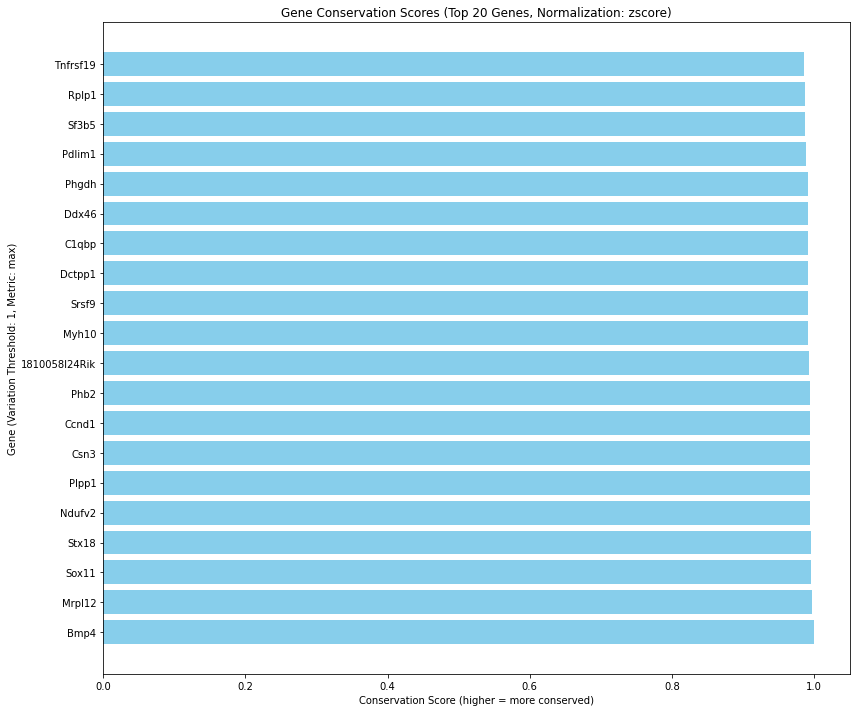

In [6]:
reshaped_data = result["reshaped_data"]

# save reshaped_data as npy file
np.save(output_dir / "reshaped_data.npy", reshaped_data)

# Define sample variation filtering parameters
VARIATION_FILTERING = {
    'off': {
        'filter_samples_by_variation': False
    },
    'basic': {
        'filter_samples_by_variation': True,
        'variation_threshold': 1,  # Minimum coefficient of variation
        'variation_metric': 'max',
        'min_valid_samples': 2       # At least 2 samples needed
    },
    'stringent': {
        'filter_samples_by_variation': True,
        'variation_threshold': 0.2, 
        'variation_metric': 'max',
        'min_valid_samples': 2
    }
}

# Choose filtering level
variation_filter_level = 'basic'  # Options: 'off', 'basic', 'stringent'
filter_params = VARIATION_FILTERING[variation_filter_level]
filtered_genes = result['filtered_genes']
print("shape of reshaped_data: ", reshaped_data.shape)
print("Start calculating trajectory conservation...")
conservation_results = calculate_trajectory_conservation(
    trajectory_data=reshaped_data,
    gene_names=filtered_genes, 
    save_dir=output_dir,
    prefix="traj_conservation",
    dtw_radius=3,            # Radius parameter for fastdtw
    use_fastdtw=True,
    normalize='zscore',      # Normalize trajectories before DTW calculation
    **filter_params          # Apply sample variation filtering
)
_ = extract_pairwise_distances(conservation_results, output_csv = output_dir / "pairwise_distances.csv")

In [8]:
conservation_results["conservation_scores"].to_csv(output_dir / "conservation_scores.csv")

In [9]:
result.keys()

dict_keys(['reshaped_data', 'binned_means', 'filtered_genes', 'batch_names', 'metadata'])

In [13]:
result["filtered_genes"]

array(['Xkr4', 'Sox17', 'Mrpl15', ..., 'Dpcd', 'Pacrgl', 'Gm10033'],
      dtype=object)

In [11]:
result["batch_names"]

['Molar_Qian',
 'Runx2_Shuo',
 'ToothNc_Junjun_P3.5',
 'ToothNiche_Hong_PN7',
 'Tooth_Zheng_M2']

In [ ]:
reshaped_data = result["reshaped_data"]

In [12]:
reshaped_data.shape

(5, 100, 15825)

In [14]:

def plot_gene_trajectory(reshaped_data, gene_idx, gene_name=None, 
                         batch_labels=None, figsize=(10, 6), 
                         cmap="viridis", save_path=None):
    """
    Plot the expression trajectory of a single gene across pseudotime for all batches.
    
    Parameters:
    -----------
    reshaped_data : numpy.ndarray
        3D array with shape (batch, pseudotime, gene)
    gene_idx : int
        Index of the gene to plot
    gene_name : str, optional
        Name of the gene for plot title
    batch_labels : list, optional
        Names of the batches for the legend
    figsize : tuple, optional
        Figure size
    cmap : str, optional
        Colormap for the batch lines
    save_path : str, optional
        Path to save the figure
        
    Returns:
    --------
    matplotlib.figure.Figure
        The figure object
    """
    # Set default gene name and batch labels if not provided
    if gene_name is None:
        gene_name = f"Gene {gene_idx}"
    
    if batch_labels is None:
        batch_labels = [f"Batch {i+1}" for i in range(reshaped_data.shape[0])]
    
    # Extract data for the specified gene
    n_batches, n_timepoints, _ = reshaped_data.shape
    gene_data = reshaped_data[:, :, gene_idx]
    
    # Create pseudotime axis
    pseudotime = np.linspace(0, 1, n_timepoints)
    
    # Set up the plot
    plt.figure(figsize=figsize)
    colors = plt.cm.get_cmap(cmap, n_batches)
    
    # Plot each batch
    for batch_idx in range(n_batches):
        plt.plot(pseudotime, gene_data[batch_idx], 
                 label=batch_labels[batch_idx],
                 color=colors(batch_idx), 
                 linewidth=2.5, 
                 alpha=0.8)
    
    # Add plot details
    plt.title(f"Expression trajectory of {gene_name} across pseudotime", fontsize=14)
    plt.xlabel("Pseudotime", fontsize=12)
    plt.ylabel("Expression level", fontsize=12)
    plt.legend(title="Batches")
    plt.grid(True, alpha=0.3)
    
    # Add a colorful background for visibility
    sns.despine(left=False, bottom=False)
    
    # Save the figure if specified
    if save_path:
        plt.tight_layout()
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.tight_layout()
    return plt.gcf()



In [15]:
np.where(filtered_genes == "Bmp4")

(array([8703]),)

/tmp/ipykernel_3418414/2779465970.py:45: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap(cmap, n_batches)


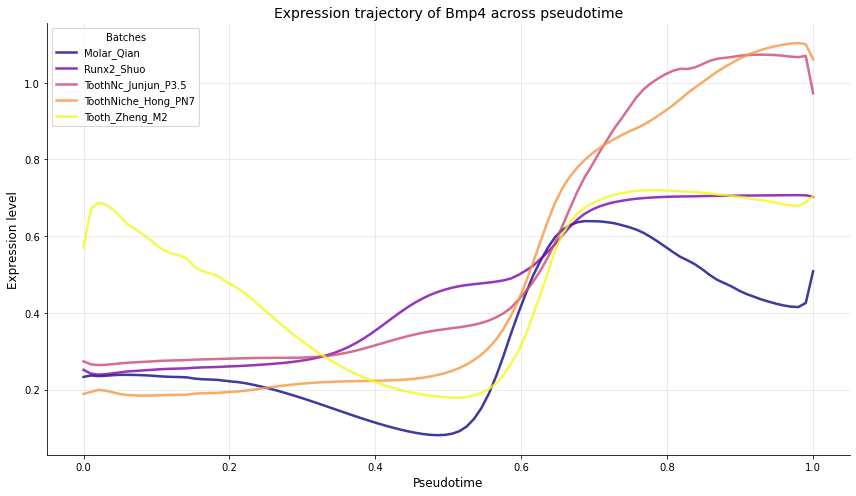

In [17]:
# Example usage:
# Choose a gene to visualize (e.g., gene index 100)
gene_to_visualize = 8703

# Optional: Define proper batch and gene names
batch_names = result["batch_names"]
allgene = result["filtered_genes"]
gene_name = "Bmp4"
gene_index = np.where(allgene == gene_name)[0][0]

# Plot the gene trajectory
fig = plot_gene_trajectory(
    reshaped_data=reshaped_data,
    gene_idx=gene_to_visualize,
    gene_name=gene_name,
    batch_labels=batch_names,
    figsize=(12, 7),
    cmap="plasma",
    save_path= output_dir / "Bmp4_trajectory.pdf"
)

plt.show()

/tmp/ipykernel_3418414/2779465970.py:45: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap(cmap, n_batches)


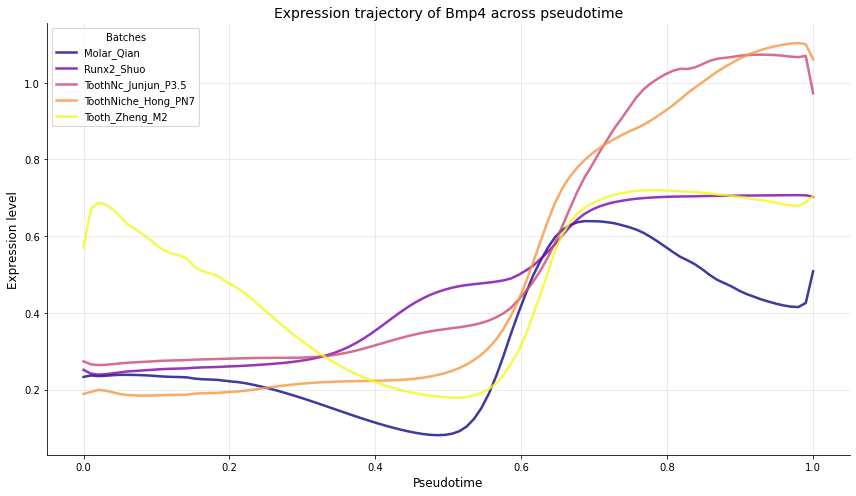

In [18]:

# Optional: Define proper batch and gene names
batch_names = result["batch_names"]
allgene = result["filtered_genes"]
gene_name = "Bmp4"
gene_index = np.where(allgene == gene_name)[0][0]

# Plot the gene trajectory
fig = plot_gene_trajectory(
    reshaped_data=reshaped_data,
    gene_idx=gene_index,
    gene_name=gene_name,
    batch_labels=batch_names,
    figsize=(12, 7),
    cmap="plasma",
    save_path= output_dir / "Bmp4_trajectory.pdf"
)

plt.show()

In [19]:
def plot_gene_by_name(gene_name, reshaped_data, result, output_dir=None, 
                      figsize=(12, 7), cmap="plasma", save_format="pdf"):
    """
    Plot a gene expression trajectory by gene name instead of index.
    This function finds the gene index by name and passes it to plot_gene_trajectory.
    
    Parameters:
    -----------
    gene_name : str
        Name of the gene to plot
    reshaped_data : numpy.ndarray
        3D array with shape (batch, pseudotime, gene)
    result : dict
        Dictionary containing 'filtered_genes' and 'batch_names'
    output_dir : str or Path, optional
        Directory to save the output file
    figsize : tuple, optional
        Figure size (width, height) in inches
    cmap : str, optional
        Colormap for the batch lines
    save_format : str, optional
        File format for saving the plot (pdf, png, jpg, etc.)
        
    Returns:
    --------
    matplotlib.figure.Figure
        The figure object
    """
    import numpy as np
    import matplotlib.pyplot as plt
    from pathlib import Path
    
    # Extract gene names and batch names from result
    allgene = result["filtered_genes"]
    batch_names = result["batch_names"]
    
    # Find the gene index by name
    try:
        gene_index = np.where(allgene == gene_name)[0][0]
    except IndexError:
        raise ValueError(f"Gene '{gene_name}' not found in filtered_genes")
    
    # Determine save path if output_dir is provided
    save_path = None
    if output_dir is not None:
        # Convert to Path object if it's a string
        if isinstance(output_dir, str):
            output_dir = Path(output_dir)
        save_path = output_dir / f"{gene_name}_trajectory.{save_format}"
    
    # Plot the gene trajectory
    fig = plot_gene_trajectory(
        reshaped_data=reshaped_data,
        gene_idx=gene_index,
        gene_name=gene_name,
        batch_labels=batch_names,
        figsize=figsize,
        cmap=cmap,
        save_path=save_path
    )
    
    return fig

# Example usage:
# fig = plot_gene_by_name("Bmp4", reshaped_data, result, output_dir=output_dir)
# plt.show()

/tmp/ipykernel_3418414/2779465970.py:45: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap(cmap, n_batches)


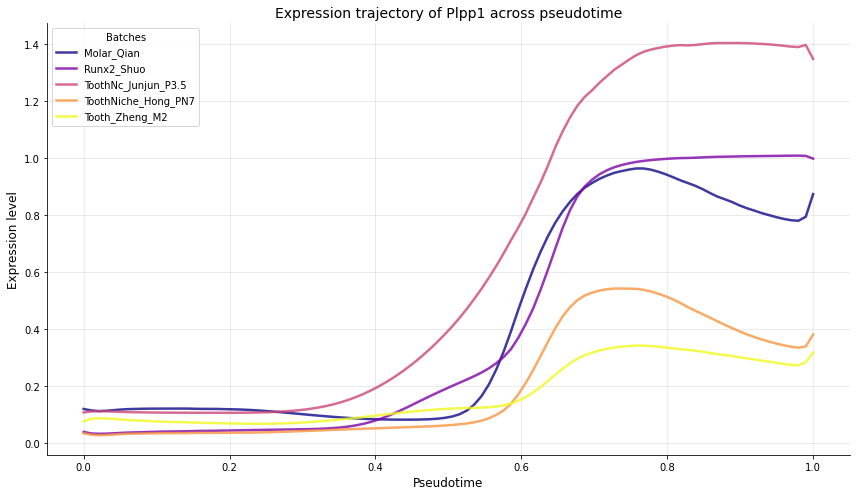

In [21]:
fig = plot_gene_by_name("Plpp1", reshaped_data, result, output_dir=output_dir)
plt.show()

/tmp/ipykernel_3418414/2779465970.py:45: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap(cmap, n_batches)


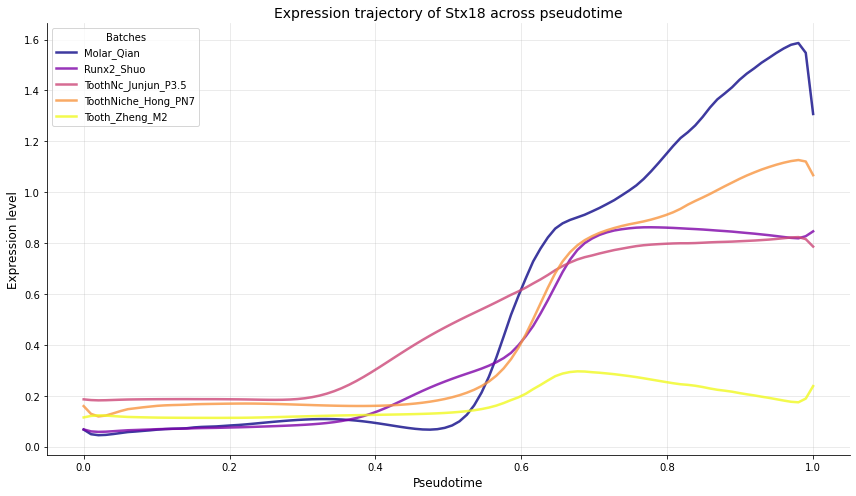

In [22]:
fig = plot_gene_by_name("Stx18", reshaped_data, result, output_dir=output_dir)
plt.show()

/tmp/ipykernel_3418414/2779465970.py:45: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap(cmap, n_batches)


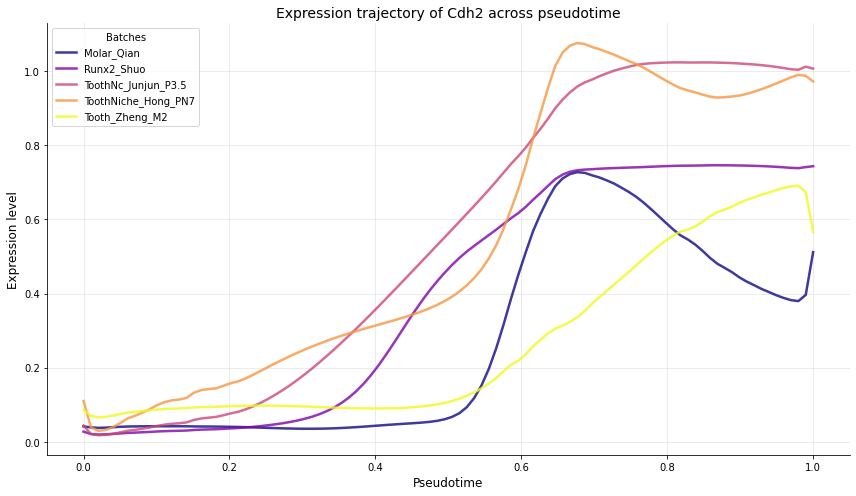

In [23]:
fig = plot_gene_by_name("Cdh2", reshaped_data, result, output_dir=output_dir)
plt.show()

/tmp/ipykernel_3418414/2779465970.py:45: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap(cmap, n_batches)


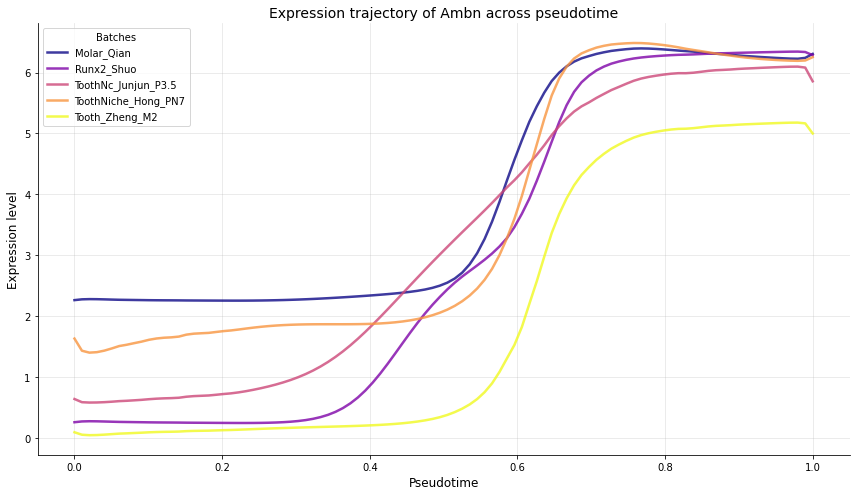

In [24]:
fig = plot_gene_by_name("Ambn", reshaped_data, result, output_dir=output_dir)
plt.show()

/tmp/ipykernel_3418414/2779465970.py:45: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap(cmap, n_batches)


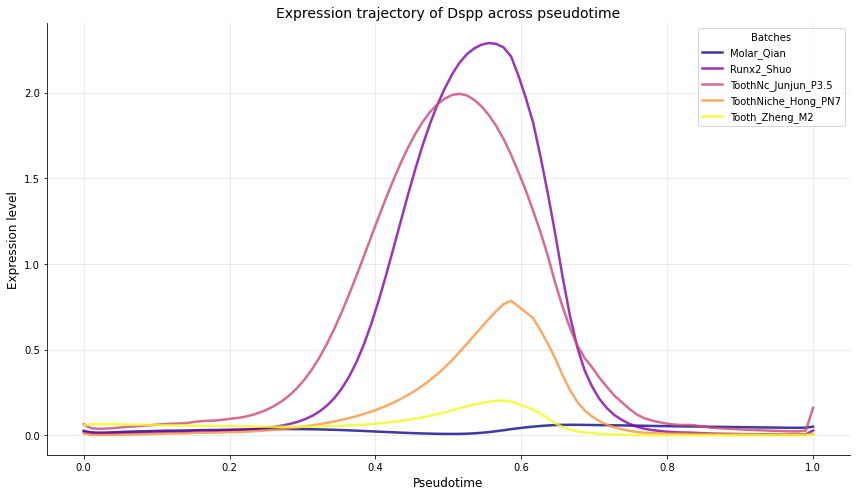

In [25]:
fig = plot_gene_by_name("Dspp", reshaped_data, result, output_dir=output_dir)
plt.show()

/tmp/ipykernel_3418414/2779465970.py:45: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap(cmap, n_batches)


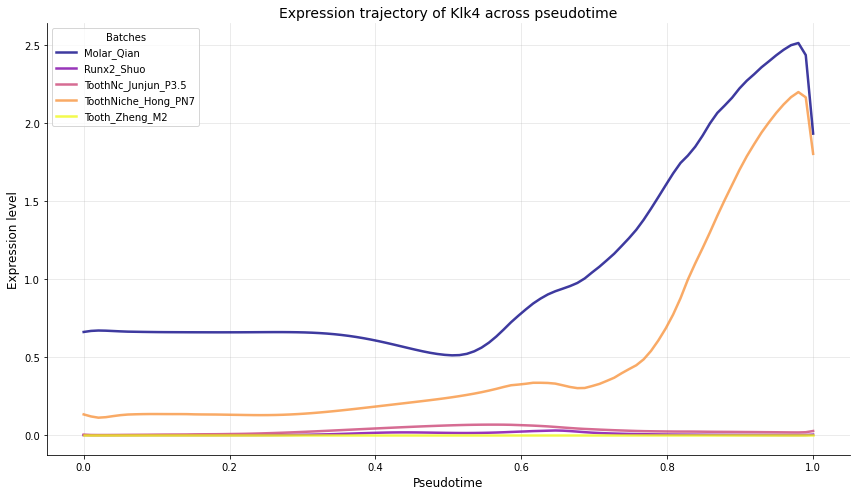

In [26]:
fig = plot_gene_by_name("Klk4", reshaped_data, result, output_dir=output_dir)
plt.show()

/tmp/ipykernel_3418414/2779465970.py:45: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap(cmap, n_batches)


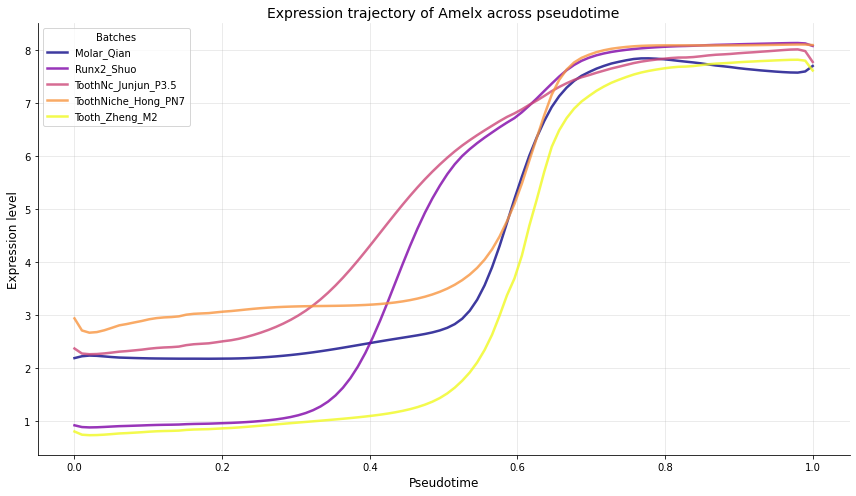

In [27]:
fig = plot_gene_by_name("Amelx", reshaped_data, result, output_dir=output_dir)
plt.show()

/tmp/ipykernel_3418414/2779465970.py:45: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap(cmap, n_batches)


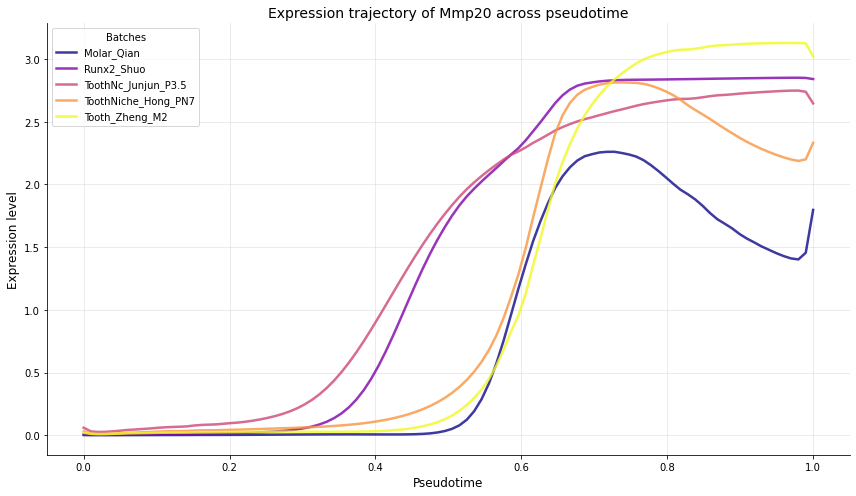

In [28]:
fig = plot_gene_by_name("Mmp20", reshaped_data, result, output_dir=output_dir)
plt.show()

/tmp/ipykernel_3418414/2779465970.py:45: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap(cmap, n_batches)


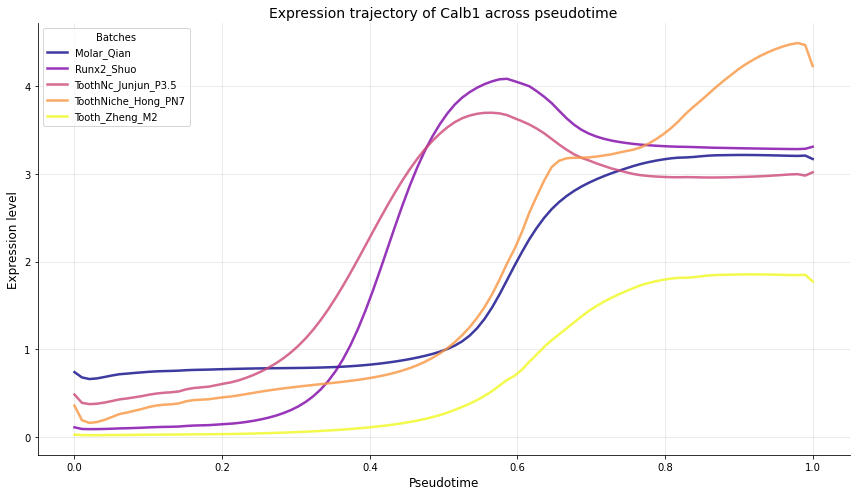

In [29]:
fig = plot_gene_by_name("Calb1", reshaped_data, result, output_dir=output_dir)
plt.show()

/tmp/ipykernel_3418414/2779465970.py:45: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap(cmap, n_batches)


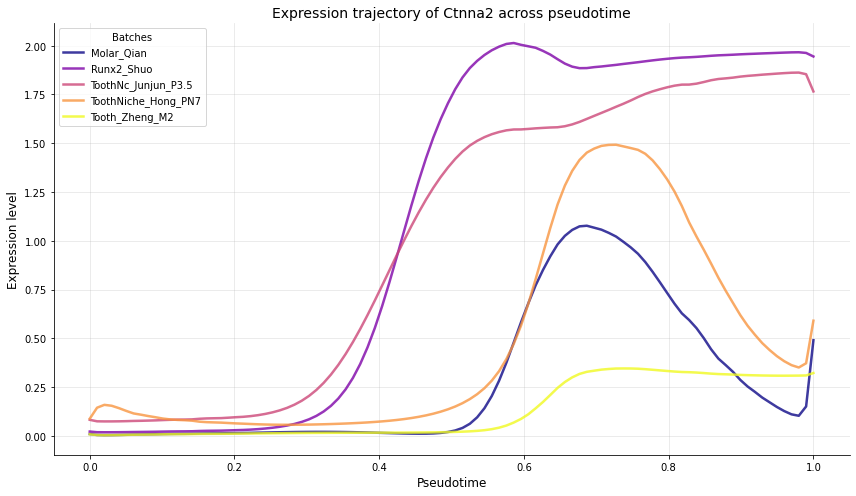

In [35]:
fig = plot_gene_by_name("Ctnna2", reshaped_data, result, output_dir=output_dir)
plt.show()

/tmp/ipykernel_3418414/2779465970.py:45: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap(cmap, n_batches)


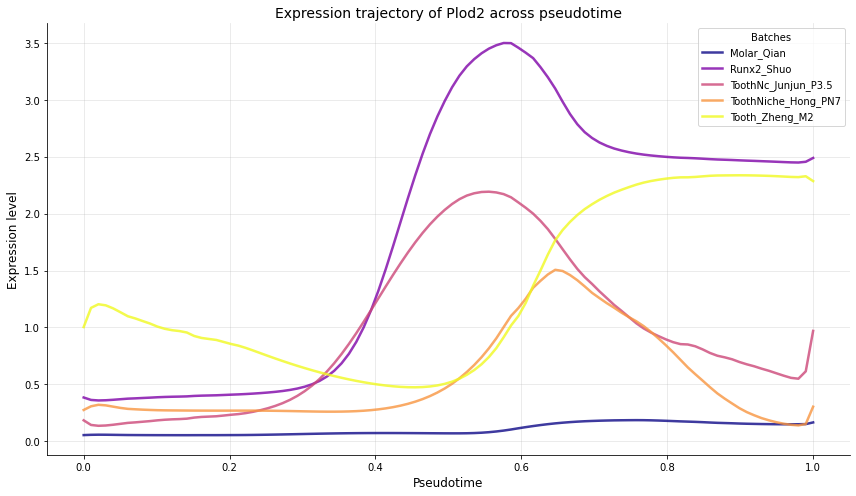

In [32]:
fig = plot_gene_by_name("Plod2", reshaped_data, result, output_dir=output_dir)
plt.show()

/tmp/ipykernel_3418414/2779465970.py:45: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap(cmap, n_batches)


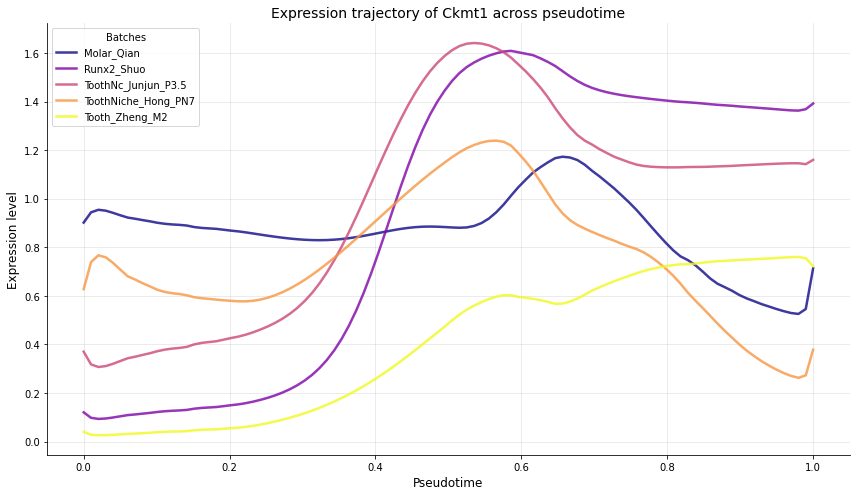

In [33]:
fig = plot_gene_by_name("Ckmt1", reshaped_data, result, output_dir=output_dir)
plt.show()

/tmp/ipykernel_3418414/2779465970.py:45: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap(cmap, n_batches)


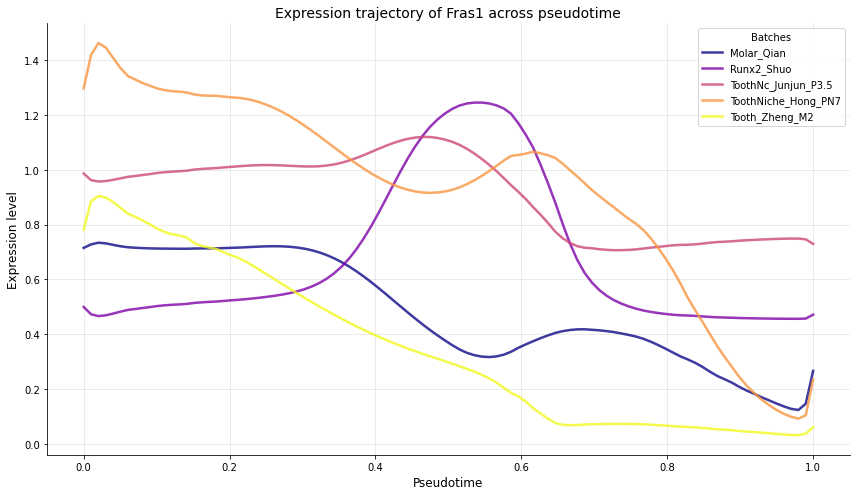

In [34]:
fig = plot_gene_by_name("Fras1", reshaped_data, result, output_dir=output_dir)
plt.show()

/tmp/ipykernel_3418414/2779465970.py:45: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap(cmap, n_batches)


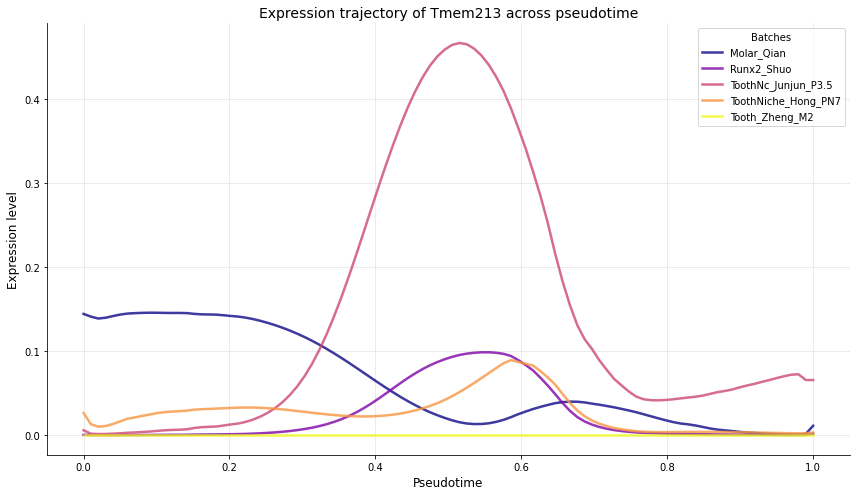

In [37]:
fig = plot_gene_by_name("Tmem213", reshaped_data, result, output_dir=output_dir)
plt.show()

/tmp/ipykernel_3418414/2779465970.py:45: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap(cmap, n_batches)


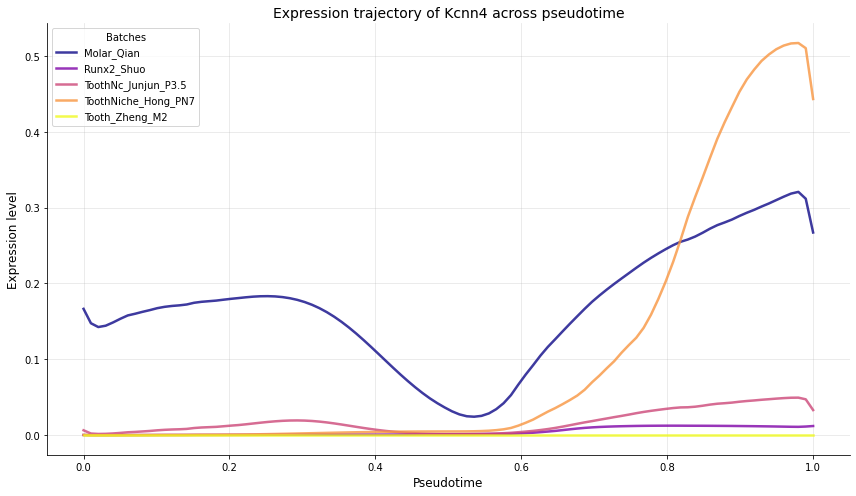

In [38]:
fig = plot_gene_by_name("Kcnn4", reshaped_data, result, output_dir=output_dir)
plt.show()